In [28]:
#import os
#from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from enum import Enum

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("max_columns",None)


In [3]:
load_dotenv()
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = f'''
    SELECT 
    (a.score_7 + a.score_8a + score_9a + score_9b + score_17a + score_21 + score_21a + score_22 + score_22a + 1) AS parenting_score_total,
    p.patient_code AS dreams_code,
    dga.nbr_presence,
    a.*
FROM
    (SELECT 
        CASE
                WHEN
                    d.a7_ak_kils_w_ap_viv_10_14 = '0'
                        OR d.a7_Ak_kiles_w_ap_viv_15_19 = '0'
                THEN
                    2
                WHEN
                    d.a7_ak_kils_w_ap_viv_10_14 = '1'
                        OR d.a7_Ak_kiles_w_ap_viv_15_19 = '1'
                THEN
                    4
                WHEN
                    d.a7_ak_kils_w_ap_viv_10_14 = '001'
                        OR d.a7_Ak_kiles_w_ap_viv_15_19 = '01'
                THEN
                    4
                WHEN
                    d.a7_ak_kils_w_ap_viv_10_14 = '03'
                        OR d.a7_Ak_kiles_w_ap_viv_15_19 = '2'
                THEN
                    4
                WHEN
                    d.a7_ak_kils_w_ap_viv_10_14 = 'lt_presize'
                        OR d.a7_Ak_kiles_w_ap_viv_15_19 = 'lt_presize'
                THEN
                    2
            END AS score_7,
            IF(d.a8_eske_gen_yon_moun_ou_santi_ou_ka_al_kote_ = '0', 0, IF(d.a8_eske_gen_yon_moun_ou_santi_ou_ka_al_kote_ = '2', 4, 0)) AS score_8a,
            IF(d.a9_ou_gen_lot_kote_ou_pa_santi_ou_ansekirite = '1', 2, 0) AS score_9a,
            IF(d.b9_list_kote_ou_pa_an_sekirite IN ('1' , '3', '2', '04'), 4, IF(d.b9_list_kote_ou_pa_an_sekirite = '4', 8, IF(d.b9_list_kote_ou_pa_an_sekirite = '0001', 2, 0))) AS score_9b,
            IF(a17 IN ('4' , '04', '004'), 8, 0) AS score_17a,
            IF(d.eske_ou_konn_bwe_alkol = 'oui', 3, 0) AS score_21,
            IF(d.a21_ske_ou_bw_alkl_osnon_itilize_lt_dwg_10_14 = '3'
                OR a21_nan_ki_frenkans_ou_itilize_alkol = '2', 6, IF(d.a21_ske_ou_bw_alkl_osnon_itilize_lt_dwg_10_14 = '5'
                OR a21_nan_ki_frenkans_ou_itilize_alkol = '5', 8, 0)) AS score_21a,
            IF(d.eske_ou_konn_itilize_dwog = 'oui', 3, 0) AS score_22,
            IF(d.ske_ou_konn_itilize_dwg_10_14 = '3'
                OR ske_ou_konn_itilize_dwg_15_19 = '2', 6, IF(d.ske_ou_konn_itilize_dwg_10_14 = '5'
                OR ske_ou_konn_itilize_dwg_15_19 = '5', 8, 0)) AS score_22a,
            d.*
    FROM
        caris_db.dreams_surveys_data d
    WHERE
        (TIMESTAMPDIFF(YEAR, d.nan_ki_dat_ou_fet, NOW()) BETWEEN 10 AND 17)
            AND (d.a7_ak_kils_w_ap_viv_10_14 NOT IN ('8' , '6')
            OR d.a7_ak_kils_w_ap_viv_10_14 IS NULL)
            AND (d.a7_Ak_kiles_w_ap_viv_15_19 NOT IN ('5' , '3')
            OR d.a7_Ak_kiles_w_ap_viv_15_19 IS NULL)) a
        LEFT JOIN
    dream_member dm ON dm.case_id = a.case_id
        LEFT JOIN
    patient p ON p.id = dm.id_patient
        LEFT JOIN
    (SELECT 
        count(distinct dgs.topic) AS nbr_presence, id_patient
    FROM
        dream_group_attendance dga1
        left join dream_group_session dgs on dga1.id_group_session=dgs.id where dga1.value="P"
    GROUP BY dga1.id_patient) dga ON dga.id_patient = dm.id_patient
WHERE
    a.total > 14
ORDER BY (a.score_7 + a.score_8a + score_9a + score_9b + score_17a + score_21 + score_21a + score_22 + score_22a + 1) DESC
'''

parenting = pd.read_sql_query(query,engine,parse_dates=True)
# get the test excel file from Query

# close the pool of connection
engine.dispose()

True

In [7]:
parenting.dreams_code.fillna("NULL",inplace=True)
parenting.dreams_code.count()

22663

In [10]:
old_data = pd.read_excel("old_data.xlsx")
old_data.dreams_code.count()

3072

## get the case_id

In [17]:
parenting_with_caseid = old_data.merge(parenting, on="dreams_code",how="left")
parenting_with_caseid.dreams_code.count()

3072

In [26]:
parenting_with_caseid.case_id.count()
old_data["case_id"] = parenting_with_caseid.case_id
old_data.case_id.count()

2981

2981

In [27]:
old_data.to_excel("liste_filles_parenting_with_CASEID.xlsx",index=False,na_rep="NULL")

In [22]:
parenting_with_caseid.to_excel("parenting_test.xlsx",index=False,na_rep="NULL")

In [30]:
%matplotlib inline
import numpy as np

In [32]:
case_plot = pd.DataFrame({"state":["Total_Eligible_Parenting","Total_CASEID_Trouve"],
                            "data": [old_data.dreams_code.count(),old_data.case_id.count()]                        
})

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'Beneficiaires Dreams Parentalite et leur CASEID')

Text(0.0, 1536.0, '3072')

Text(1.0, 1490.5, '2981')

Text(-80, -20, 'source: HIVHaiti')

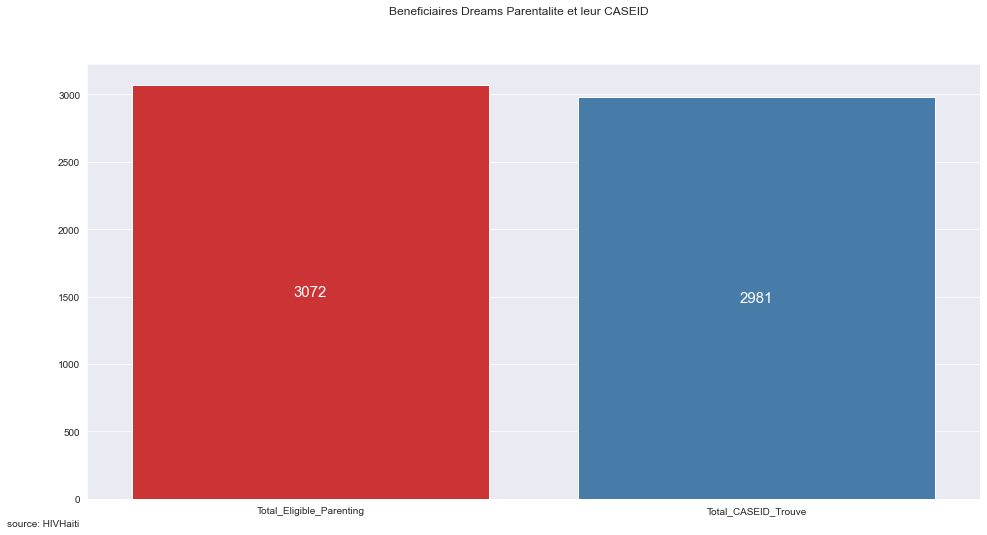

In [39]:
plt.subplots(figsize=(16,8))
sns.set_style("darkgrid")
sns.set_palette("Set1")
splot = sns.barplot(x="state",y="data",data=case_plot)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("Beneficiaires Dreams Parentalite et leur CASEID")
for p in splot.patches:
    height = p.get_height()
    plt.text(
                p.get_x() + p.get_width()/2, 
                0.5*p.get_height() + p.get_y(),
                '{:1.0f}'.format(height), 
                ha='center', va='center',
                size=15,
                fontdict=dict(color="white",fontsize=15)
            )
    
plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)
plt.savefig("parenting_caseid",dpi=1000)